► Please select your Excel file (sheet='BTC_Hourly'):


Saving btc_200d_indicators.xlsx to btc_200d_indicators (1).xlsx


<ipython-input-5-f98e1011888b>:142: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_tf = df_raw.resample(tf).last().dropna()


--- 1H ---


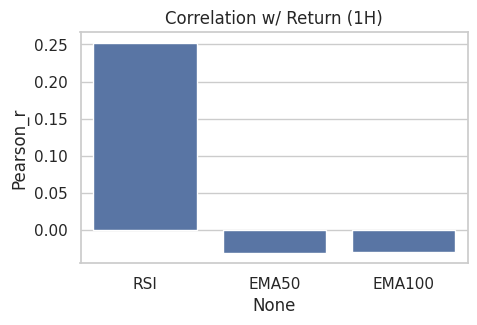

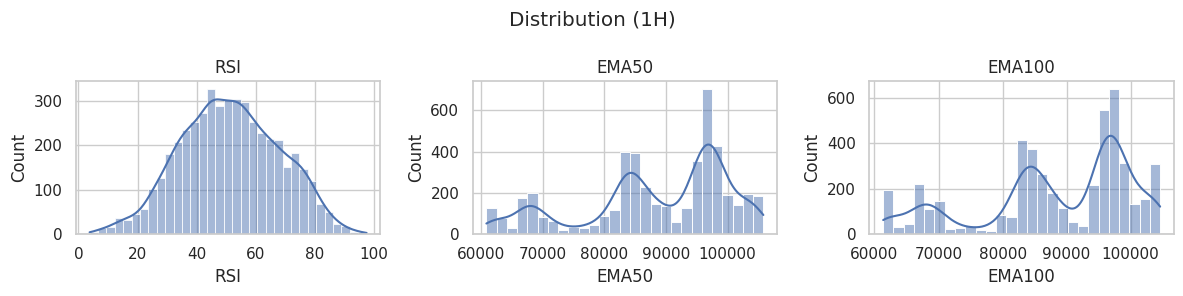

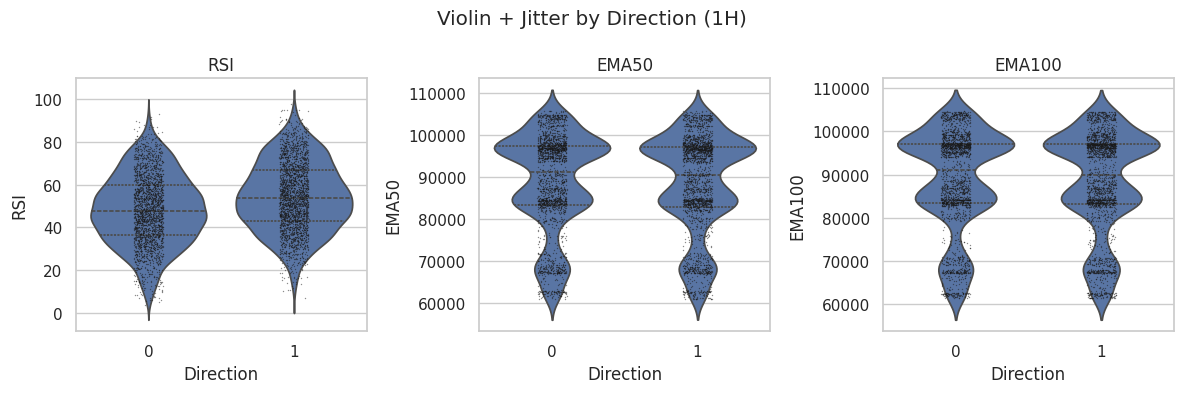

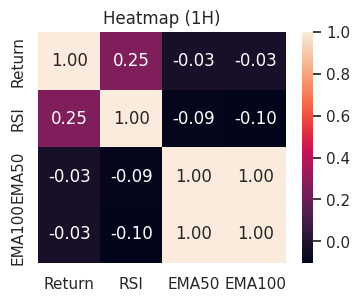

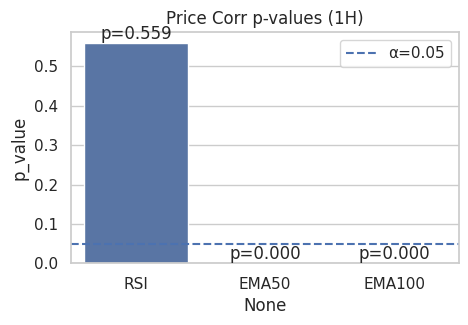

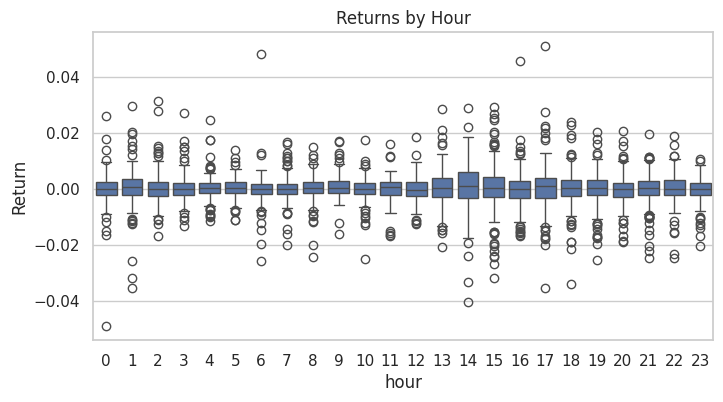

<Figure size 800x300 with 0 Axes>

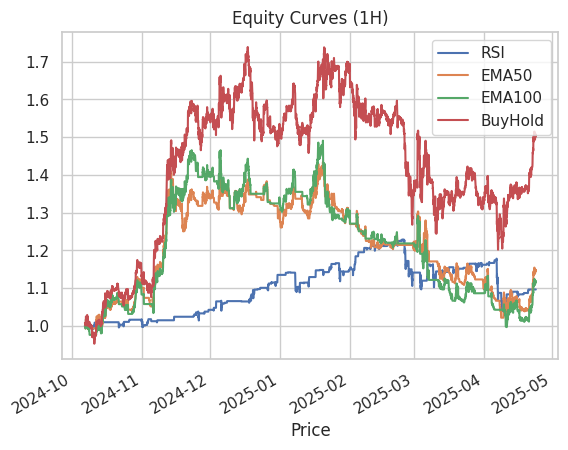

Logistic AUC (1H): 0.601
--- 2H ---


<ipython-input-5-f98e1011888b>:142: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_tf = df_raw.resample(tf).last().dropna()


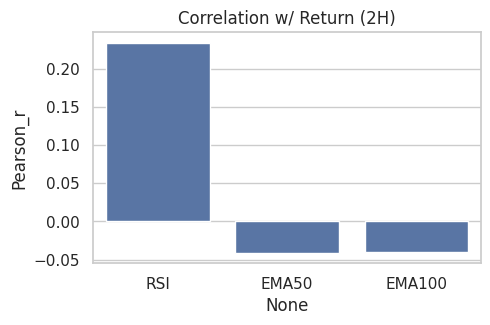

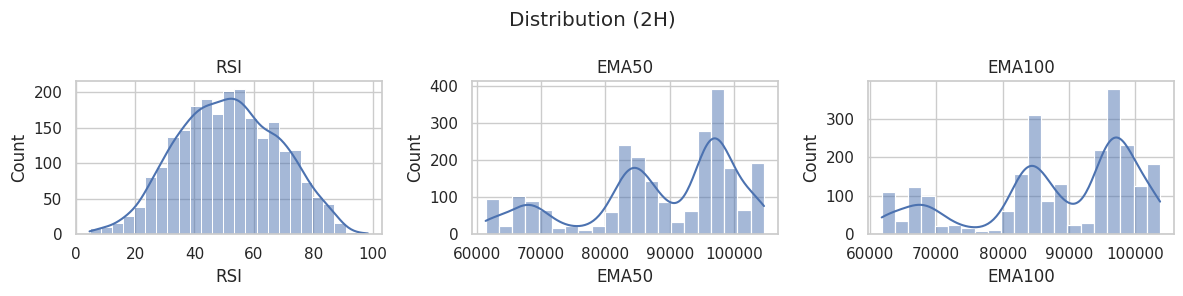

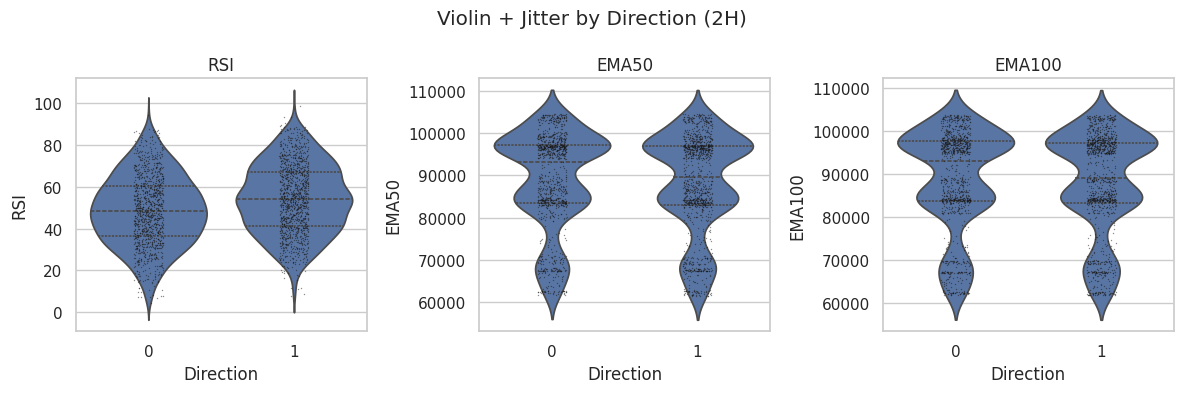

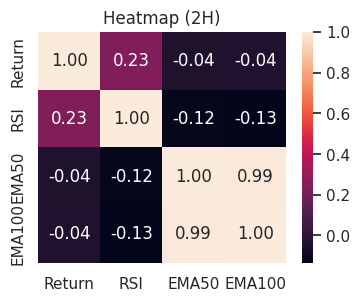

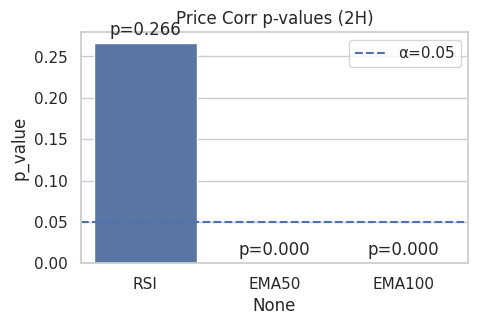

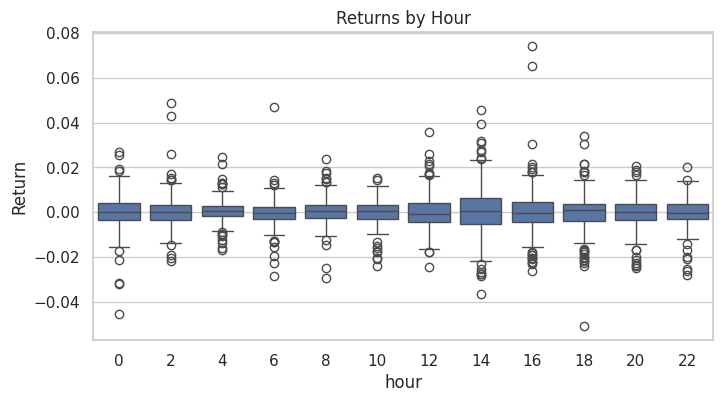

<Figure size 800x300 with 0 Axes>

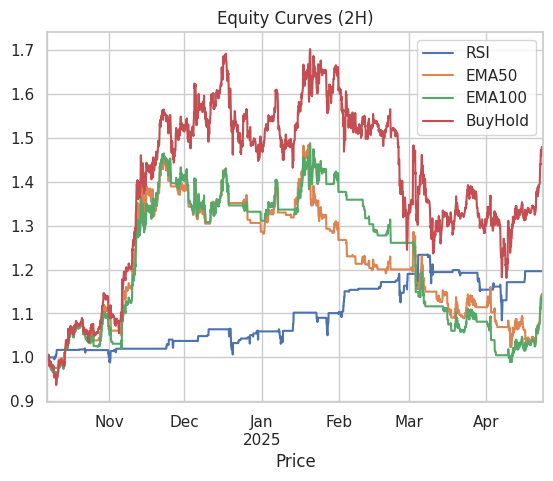

Logistic AUC (2H): 0.594
--- 3H ---


<ipython-input-5-f98e1011888b>:142: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_tf = df_raw.resample(tf).last().dropna()


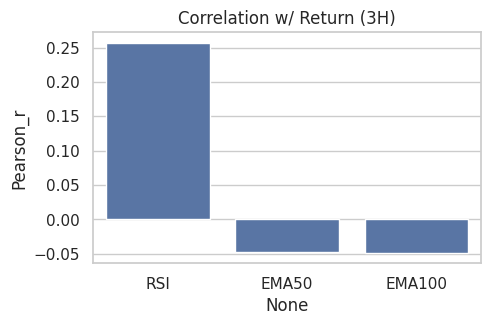

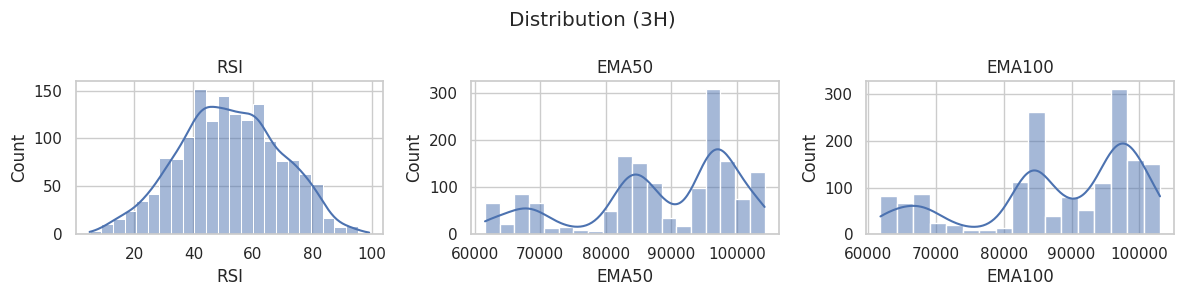

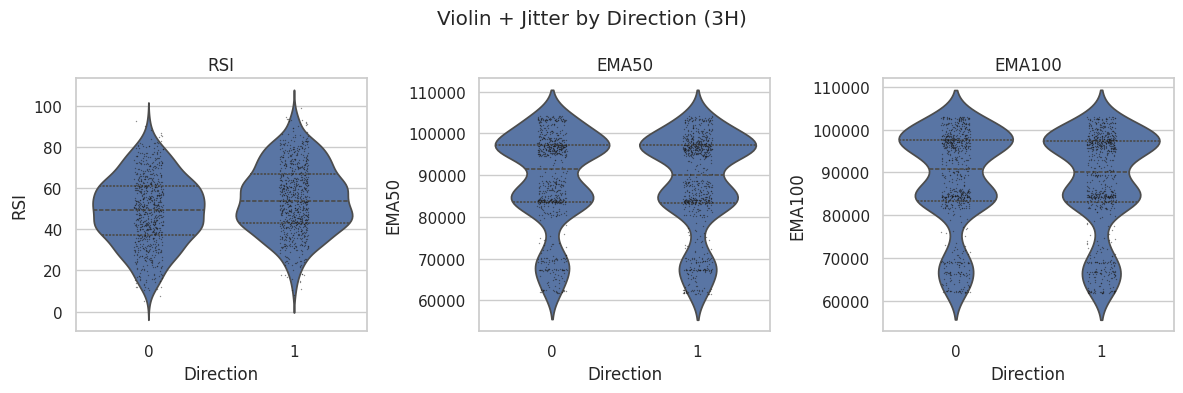

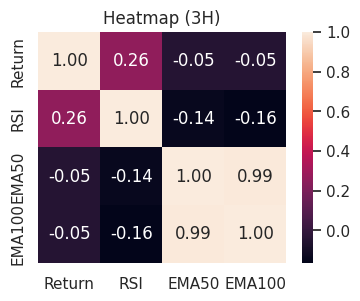

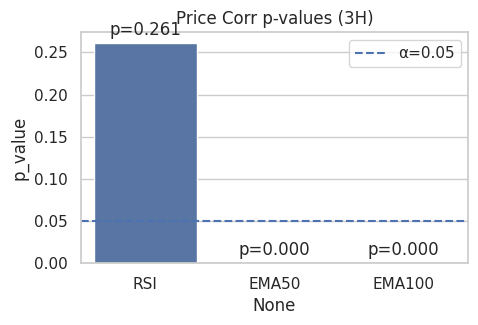

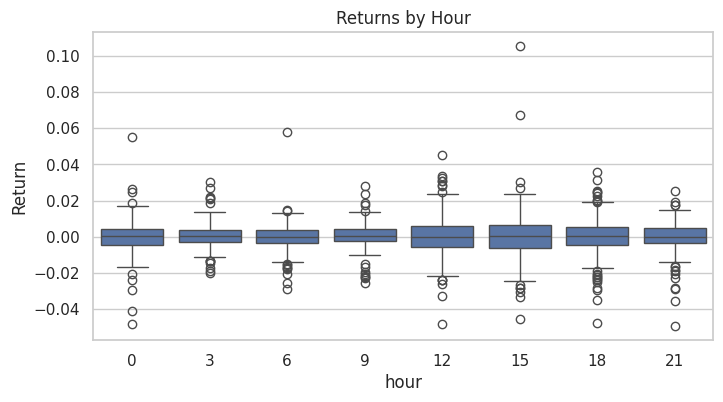

<Figure size 800x300 with 0 Axes>

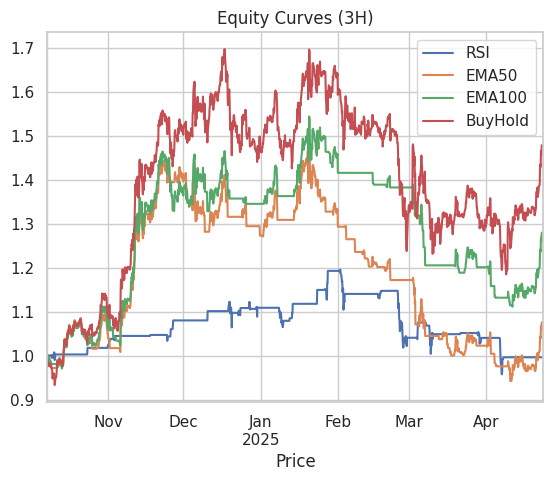

Logistic AUC (3H): 0.598
--- 4H ---


<ipython-input-5-f98e1011888b>:142: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_tf = df_raw.resample(tf).last().dropna()


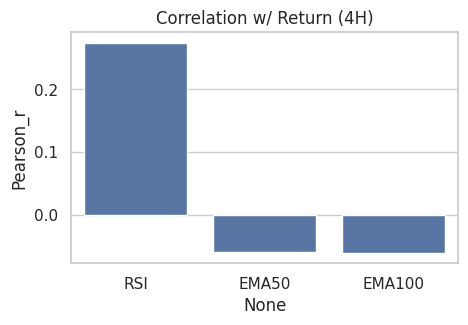

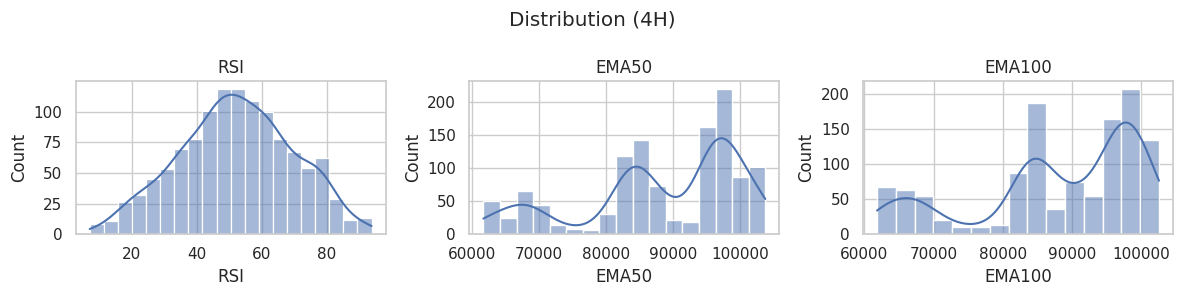

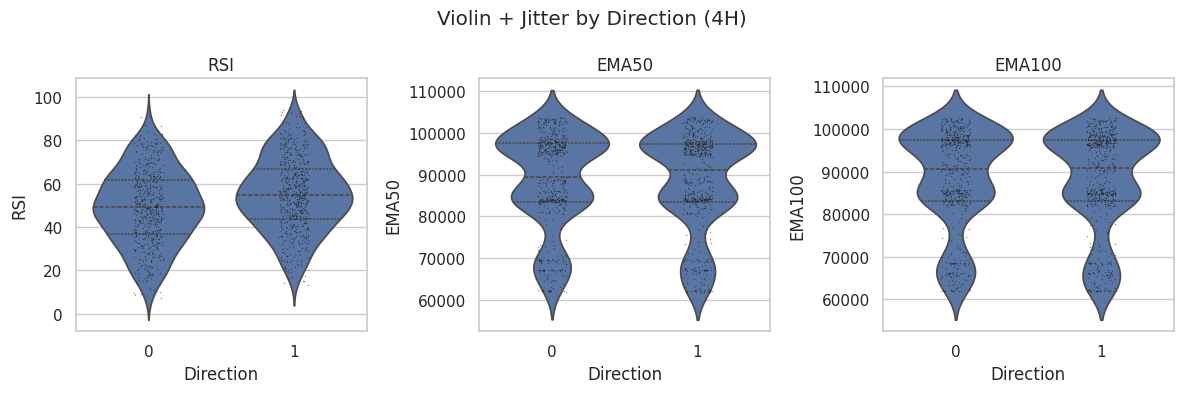

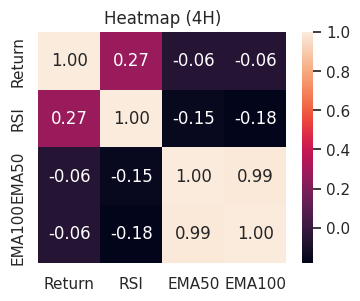

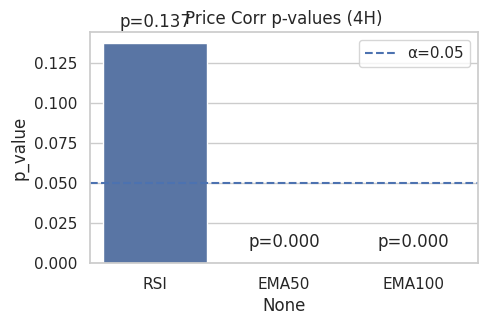

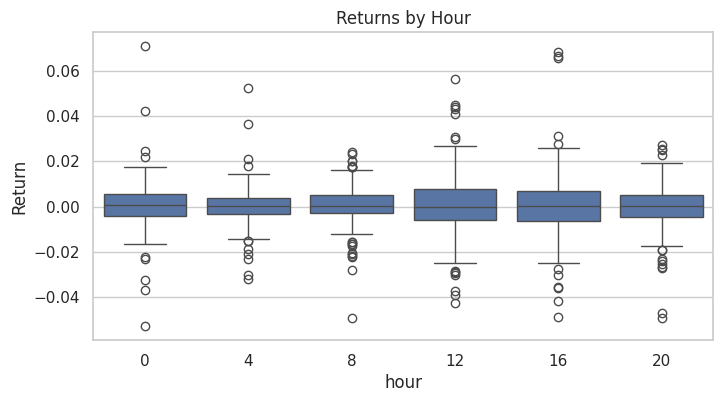

<Figure size 800x300 with 0 Axes>

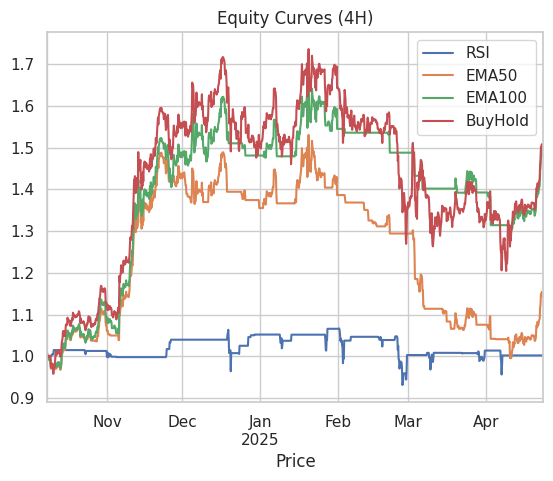

Logistic AUC (4H): 0.596


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from statsmodels.formula.api import ols, logit
from sklearn.metrics import roc_auc_score

sns.set(style="whitegrid")

# --- 1) Data loading and indicator calculation ---
def load_and_preprocess(fname, sheet='BTC_Hourly'):
    df = pd.read_excel(fname, sheet_name=sheet, skiprows=[1,2], index_col=0, engine='openpyxl')
    df.index = pd.to_datetime(df.index)
    df = df[['Close']].dropna()
    return df


def compute_indicators(df):
    df = df.copy()
    # EMAs
    df['EMA50']  = df['Close'].ewm(span=50, adjust=False).mean()
    df['EMA100'] = df['Close'].ewm(span=100, adjust=False).mean()
    # RSI
    delta     = df['Close'].diff()
    gain      = delta.clip(lower=0)
    loss      = -delta.clip(upper=0)
    avg_gain  = gain.rolling(14).mean()
    avg_loss  = loss.rolling(14).mean()
    df['RSI'] = 100 - (100 / (1 + avg_gain / avg_loss))
    # Returns
    df['Return'] = df['Close'].pct_change()
    df.dropna(inplace=True)
    return df

# --- 2) Analysis ---
def analyze(df):
    # Correlations with Return
    corr_vals = {col: pearsonr(df[col], df['Return'])[0] for col in ['RSI','EMA50','EMA100']}
    corr_df = pd.DataFrame.from_dict(corr_vals, orient='index', columns=['Pearson_r'])

    # Regression & classification
    lm = ols('Return ~ RSI + EMA50 + EMA100', data=df).fit()
    df['Direction'] = (df['Return'] > 0).astype(int)
    logm = logit('Direction ~ RSI + EMA50 + EMA100', data=df).fit(disp=False)
    auc = roc_auc_score(df['Direction'], logm.predict(df))

    # Strategy signals and equity
    signals = pd.DataFrame({
        'RSI':    (df['RSI'] < 30).astype(int),
        'EMA50':  (df['Close'] > df['EMA50']).astype(int),
        'EMA100': (df['Close'] > df['EMA100']).astype(int)
    }).shift(1).fillna(0)
    strat = signals.multiply(df['Return'], axis=0)
    equity = (1 + strat).cumprod()
    equity['BuyHold'] = (1 + df['Return']).cumprod()

    # Correlation with Price significance
    sig = {}
    for col in ['RSI','EMA50','EMA100']:
        r, p = pearsonr(df[col], df['Close'])
        sig[col] = {'r': r, 'p_value': p}
    sig_df = pd.DataFrame(sig).T
    return df, corr_df, lm, auc, strat, equity, sig_df

# --- 3) Visualization functions ---

def plot_corr_bar(corr_df, title):
    plt.figure(figsize=(5,3))
    sns.barplot(x=corr_df.index, y='Pearson_r', data=corr_df.reset_index().rename(columns={'index':'Indicator'}))
    plt.title(title)
    plt.show()


def plot_histograms(df, cols, title):
    fig, axes = plt.subplots(1, len(cols), figsize=(4*len(cols),3))
    for ax, col in zip(axes, cols):
        sns.histplot(df[col], kde=True, ax=ax)
        ax.set_title(col)
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()


def plot_violin_scatter(df, cols, hue, title):
    fig, axes = plt.subplots(1, len(cols), figsize=(4*len(cols),4))
    for ax, col in zip(axes, cols):
        sns.violinplot(x=df[hue], y=df[col], ax=ax, inner='quartile')
        sns.stripplot(x=df[hue], y=df[col], ax=ax, color='k', size=1, alpha=0.5)
        ax.set_title(col)
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()


def plot_corr_heatmap(df, cols, title):
    corr = df[cols].corr()
    plt.figure(figsize=(4,3))
    sns.heatmap(corr, annot=True, fmt='.2f')
    plt.title(title)
    plt.show()


def plot_price_corr_significance(sig_df, title, alpha=0.05):
    plt.figure(figsize=(5,3))
    sns.barplot(x=sig_df.index, y='p_value', data=sig_df.reset_index().rename(columns={'index':'Indicator'}))
    plt.axhline(alpha, linestyle='--', label=f'α={alpha}')
    for i, p in enumerate(sig_df['p_value']):
        plt.text(i, p + 0.01, f"p={p:.3f}", ha='center')
    plt.title(title)
    plt.legend()
    plt.show()


def plot_returns_by_hour(df):
    df_ = df.copy()
    df_['hour'] = df_.index.hour
    plt.figure(figsize=(8,4))
    sns.boxplot(x='hour', y='Return', data=df_)
    plt.title('Returns by Hour')
    plt.show()


def plot_equity(equity, title):
    plt.figure(figsize=(8,3))
    equity.plot()
    plt.title(title)
    plt.legend(loc='best')
    plt.show()

# --- 4) Main execution ---
if __name__ == '__main__':
    from google.colab import files
    print("► Please select your Excel file (sheet='BTC_Hourly'):")
    uploaded = files.upload()
    fname = next(iter(uploaded.keys()))

    df_raw = load_and_preprocess(fname)
    timeframes = ['1H','2H','3H','4H']

    for tf in timeframes:
        df_tf = df_raw.resample(tf).last().dropna()
        df_ind = compute_indicators(df_tf)
        df, corr_df, lm, auc, strat, equity, sig_df = analyze(df_ind)

        print(f"--- {tf} ---")
        plot_corr_bar(corr_df, f"Correlation w/ Return ({tf})")
        plot_histograms(df, ['RSI','EMA50','EMA100'], f"Distribution ({tf})")
        plot_violin_scatter(df, ['RSI','EMA50','EMA100'], 'Direction', f"Violin + Jitter by Direction ({tf})")
        plot_corr_heatmap(df, ['Return','RSI','EMA50','EMA100'], f"Heatmap ({tf})")
        plot_price_corr_significance(sig_df, f"Price Corr p-values ({tf})")
        plot_returns_by_hour(df)
        plot_equity(equity, f"Equity Curves ({tf})")
        print(f"Logistic AUC ({tf}): {auc:.3f}")
